# Project - Building a Restaurant Recommendation System

Link for the submission - https://drive.google.com/drive/folders/1yG_sHXO9HluqhL6LU4PV8A-JLWJOIbPh?usp=sharing

## Team - Flipping - a - Coin 
### 1. Devansh Shrestha
### 2. Lakshay Chawla
### 3. Rommel Jalasutram
### 4. Varnika Vatsyayan

### Aim - To build a restaurant recommendation based on yelp dataset using various techniques.

# Introduction -
#### We got our datasetr from yelp. The dataset contains 5 tables namely
##### 1.Business
##### 2.User
##### 3.Review
##### 4.Checkin
##### 5.Tip
#### Reading the dataset from a tar file , and then converting it to CSV files.
#### We performed EDA on the dataset and then came up with a plan of action. 
#### Firstly, we used item-item collaborative based filtering using cosine similarity. 
#### Second, we used embeddings of latent factors using stoichastic gradient descent. 
#### Last but not the least, we implemented a hybrid of the above two.

## Libraries to be used

In [ ]:
import tarfile
import json
import pandas as pd
import os
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from pywaffle import Waffle
from scipy import spatial
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten,Reshape,Dense,Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from sklearn import  preprocessing
from IPython.display import Image

## Extracting the files

In [ ]:
%pwd

'C:\\Users\\laksh\\Downloads\\CODES\\Course\\DS-1\\Project'

In [ ]:
# open file
file = tarfile.open('yelp_photos.tar')
  
# print file names
print(file.getnames())
  
# extract files
file.extractall('yelp_photos')
  
# close file
file.close()

In [ ]:
for i, walk_items in enumerate(os.walk(dataset_path)):
    for j in walk_items[2]:
        if j.split('.')[-1] == 'json':    
            temp = [json.loads(line) for line in open(f'{j}','rb')]
            df = pd.DataFrame.from_dict(temp)
            df.to_csv(f"{j.split('.')[-2].split('_')[-1]}.csv")
    break

In [ ]:
cd C:\\Users\\laksh\\Downloads\\CODES\\Course\\DS-1\\Project\\csv

C:\Users\laksh\Downloads\CODES\Course\DS-1\Project\csv


In [ ]:
## Setting the dataset path.
dataset_path = %pwd

## EDA and Pre-processing

In [ ]:
## Reading all the csv files
for i, walk_items in enumerate(os.walk(dataset_path)):
    for j in walk_items[2]:
        globals()[j.split('.')[0]] = pd.read_csv(f'{j}', index_col=0)

In [ ]:
dataframes = [business, checkin, review, tip, user]
names = ['Business', 'Checkin', 'Review', 'Tip', 'User']

In [ ]:
pt = PrettyTable()
pt.field_names = ["Table Name","Shape"]
for i in range(len(names)):
    pt.add_row([names[i],dataframes[i].shape])
print(pt)

+------------+---------------+
| Table Name |     Shape     |
+------------+---------------+
|  Business  |  (150346, 14) |
|  Checkin   |  (131930, 2)  |
|   Review   |  (6990280, 9) |
|    Tip     |  (908915, 5)  |
|    User    | (1987897, 22) |
+------------+---------------+


In [ ]:
for j in range(len(names)):
    print(f'Null Values for table {names[j]}')
    pt = PrettyTable()
    pt.field_names = ["Column Name","Percentage of null values"]
    for i in range(len(dataframes[j].columns)):
        pt.add_row([(dataframes[j].isnull().astype(int).sum()/len(dataframes[j])).index[i],round(((dataframes[j].isnull().astype(int).sum()/len(dataframes[j]))[i]*100),4)])
    print(pt)
    print(f'Datatypes of table {names[j]}')
    pt = PrettyTable()
    pt.field_names = ["Column Name","Data Type"]
    for i in range(len(dataframes[j].columns)):
        pt.add_row([dataframes[j].dtypes.index[i],dataframes[j].dtypes[i]])
    print(pt)
    print(f'Unique datatypes in table {names[j]}')
    temp = {}
    for i in dataframes[j].dtypes:
        if i in temp.keys():
            temp[i] = temp[i] + 1
        else:
            temp[i] = 1
    pt = PrettyTable()
    pt.field_names = ["Data Type","Number of Occurences"]
    for i,j in temp.items():
        pt.add_row([i,j])
    print(pt)
    print('---------------------------------------------------------------------------')

Null Values for table Business
+--------------+---------------------------+
| Column Name  | Percentage of null values |
+--------------+---------------------------+
| business_id  |            0.0            |
|     name     |            0.0            |
|   address    |           3.4101          |
|     city     |            0.0            |
|    state     |            0.0            |
| postal_code  |           0.0486          |
|   latitude   |            0.0            |
|  longitude   |            0.0            |
|    stars     |            0.0            |
| review_count |            0.0            |
|   is_open    |            0.0            |
|  attributes  |           9.1416          |
|  categories  |           0.0685          |
|    hours     |          15.4464          |
+--------------+---------------------------+
Datatypes of table Business
+--------------+-----------+
| Column Name  | Data Type |
+--------------+-----------+
| business_id  |   object  |
|     name     

### Table Business

In [ ]:
n_items = 100

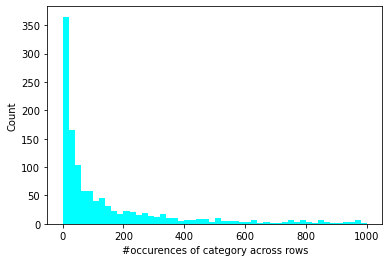

A lot of categories occurs in few rows
Considering top 100 categories
value of hundredth category " Eyelash Service ": 1278


In [ ]:
# one hot encoding categories column
categories_columns={}
def split_categories(cat):
  row = str(cat).split(',')
  ret_row=[]
  for i in row:
    if i[0]==" ": # remove the blank space at begining of some strings
      i = i[1:]
    elif i[-1]==' ':
      i=i[:-1]
    ret_row.append(i)
    if i not in categories_columns.keys():
      categories_columns[i]=1
    else:
      categories_columns[i]+=1 
  return ret_row
  
df_columns=business.categories.apply(split_categories)

# sort based on number of occurence
categories_columns=sorted(categories_columns.items(), key =lambda kv:[kv[1], kv[0]],reverse=True)

dt=np.dtype('object,int')
cat_items=np.array(categories_columns,dtype=dt)
plt.hist(cat_items['f1'],range=(0,1000),bins=50,color="cyan")
plt.ylabel('Count')
plt.xlabel('#occurences of category across rows')
plt.show()
print('A lot of categories occurs in few rows')
print('Considering top 100 categories')
categories_columns = cat_items['f0'][:100]
print('value of hundredth category "',cat_items['f0'][99],'":',cat_items['f1'][99])# one hot encoding categories column
categories_columns={}

In [ ]:
no_cols = len(categories_columns)
category_ohe = {}
for idx,val in df_columns.items():
  row = np.zeros(no_cols)
  row=row.astype('int')
  for i,v in  enumerate(categories_columns):
    if v in val:
      row[i]=int(1)
  category_ohe[idx]=row

In [ ]:
cols_ohe=pd.DataFrame(category_ohe.values(),columns=categories_columns)
cols_ohe.head()

,Restaurants,Food,Shopping,Home Services,Beauty & Spas,Nightlife,Health & Medical,Local Services,Bars,Automotive,...,Financial Services,Trainers,Hair Stylists,Arts & Crafts,Department Stores,Electronics,Veterinarians,Massage Therapy,Pet Sitting,Eyelash Service
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# One hot encode State column
print("Unique states in df:",len(np.unique(business.state.values)))
df_state_ohe =pd.get_dummies(business[['state']])

Unique states in df: 27


In [ ]:
def get_attributes(s,cat_columns,index=None):
  field_dict={}
  zero_text = ['None','False','none','false','no']
  pars_table={ord('\''):None,ord('"'):None,ord('{'):ord(' '),ord('}'):None}
  # return None if already none
  if type(s) == float or type(s)== np.nan:
    return None

  # clean the  entry  
  s=s.replace('"u\'','\'').replace(' u','').replace('{u','{')
  s=s.translate(pars_table)
  s=s.replace(' BusinessParking: ','').replace(' ','').replace('Ambience:','' )
  s=s.replace('GoodForMeal:','').replace('Music:','').replace('BestNights:','').replace('DietaryRestrictions:','')
  
  att=s.split(',') # split each attribute

  # get attribute values
  for field in att:
    if field =='None'or field=='':
      continue
    f_split=field.split(':')
    attri = f_split[0]
    val = f_split[1]   
    if val in zero_text:
      val = 0     
    elif val in ['True']:
      val = 1
    elif attri in cat_columns:
      val = str(val)
      field_dict[attri]=val
      continue

    try:
      val=int(val)
    except:
      print('Unknown type')
      print(val,index)
    # update dict

    field_dict[attri]=val

  return field_dict

In [ ]:
unique_attributes=[]
row_attr =[]
cat_columns=['RestaurantsAttire','Alcohol','NoiseLevel','HairSpecializesIn','WiFi','BYOBCorkage','Smoking','AgesAllowed']
for index, row in business[['attributes']].iterrows():
  attr_dict=get_attributes(row['attributes'],cat_columns=cat_columns,index=index)
  if attr_dict == None:
    row_attr.append({})
    continue
  for k in list(attr_dict.keys()):
    if k not in unique_attributes:
      unique_attributes.append(k)
  row_attr.append(attr_dict)

In [ ]:
# create a dataframe from row attributes
df_attributes=pd.DataFrame(row_attr,columns=unique_attributes)
df_attributes=df_attributes.fillna(0)

In [ ]:
# one hot encode categorical columns
df_attr_cat=pd.get_dummies(df_attributes[cat_columns])
df_attributes.drop(cat_columns,axis=1,inplace=True)
df_attributes=df_attributes.astype('int32')
#numerical_cols=df_attributes.columns

In [ ]:
df_attributes=pd.concat([df_attributes,df_attr_cat],axis=1)
df_attributes.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,garage,street,...,BYOBCorkage_0,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,Smoking_0,Smoking_outdoor,Smoking_yes,AgesAllowed_0,AgesAllowed_18plus,AgesAllowed_21plus,AgesAllowed_allages
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
2,0,1,1,2,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
3,0,0,1,1,0,1,0,1,0,1,...,1,0,0,1,0,0,1,0,0,0
4,0,1,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [ ]:
business.drop(['attributes','categories','state'],axis=1,inplace=True)

In [ ]:
df_final_buisness = pd.concat([business,df_attributes,cols_ohe,df_state_ohe],axis=1)

In [ ]:
df_final_buisness.to_csv('df_pp_buisness.csv',index=False)

### Table User

In [ ]:
df_users=df_users[df_users['review_count']>2]

### Table Review

In [ ]:
df_review['stars']=df_review['stars'].astype('int32')

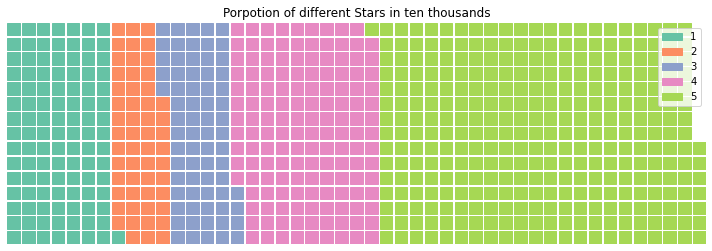

In [ ]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

stars=df_review.groupby('stars')['stars'].count()
star_count=[(i//10000) for i in stars.values]
label=[str(i) for i in list(stars.index)]

plt.figure(FigureClass=Waffle,rows=15,values=star_count,labels=label)
plt.title('Porpotion of different Stars in ten thousands') 
plt.show()

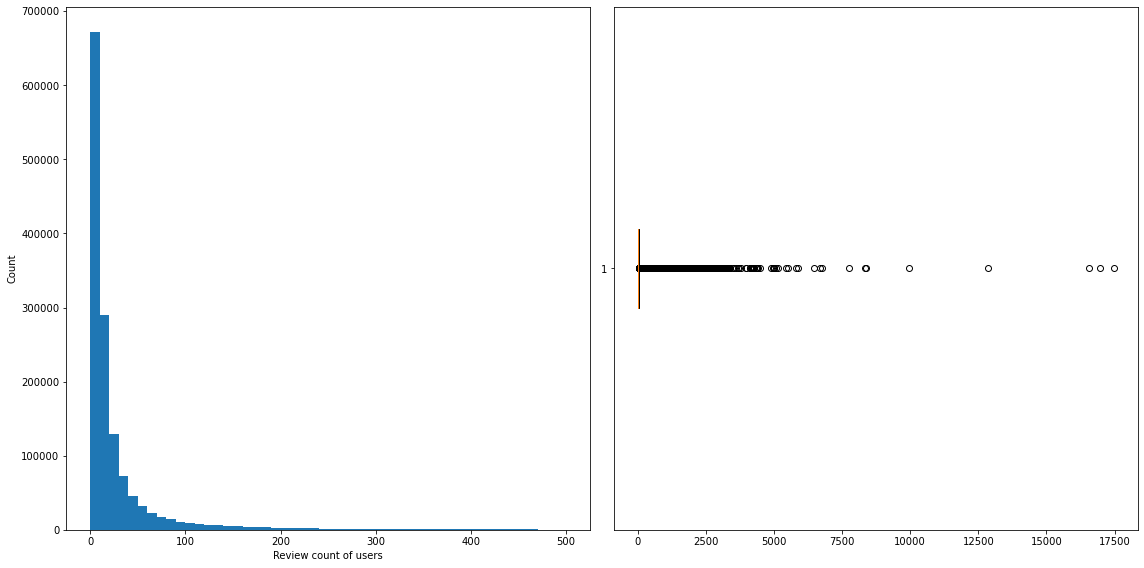

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,8))
ax[0].hist(df_users.review_count,bins=50,range=(0,500))
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Review count of users')
ax[1].boxplot(df_users.review_count,vert=False)
plt.show()

In [ ]:
most_rated_items=df_review.groupby(['business_id'])['business_id'].count().sort_values(ascending=False)
print(f'considering top {n_items} most rated items')

considering top 100 most rated items


In [ ]:
most_rated_items=most_rated_items.iloc[0:n_items].index

In [ ]:
# create a df which contains top n items and respective user that reviewed along with review
user_item=df_review[df_review['business_id'].isin(most_rated_items)][['user_id','business_id','stars']]
user_item.reset_index(drop=True,inplace=True)
stars_top_rated_items = user_item.groupby('business_id').mean('stars')

In [ ]:
unique_items=user_item['business_id'].unique()
print('No of unique items:',len(unique_items))

No of unique items: 100


In [ ]:
unique_user = user_item['user_id'].unique()
null_ui_mat={}
for i in unique_user:
  r = list(np.zeros(len(unique_items)))
  null_ui_mat[i]=r

In [ ]:
UI_matrix = pd.DataFrame.from_dict(null_ui_mat,columns=unique_items,orient='index').astype('int32')

In [ ]:
UI_matrix.head()

,PY9GRfzr4nTZeINf346QOw,W4ZEKkva9HpAdZG88juwyQ,SZU9c8V2GuREDN5KgyHFJw,Zi-F-YvyVOK0k5QD7lrLOg,GBTPC53ZrG1ZBY3DT8Mbcw,pSmOH4a3HNNpYM82J5ycLA,8uF-bhJFgT4Tn6DTb27viA,UCMSWPqzXjd7QHq7v8PJjQ,vN6v8m4DO45Z4pp8yxxF_w,g04aAvgol7IW8buqSbT4xA,...,oBNrLz4EDhiscSlbOl8uAw,skY6r8WAkYqpV7_TxNm23w,iRIHK8-EwpeffwvoO4nzIA,OdIBX09glfXNVSyd0RnIeg,qQO7ErS_RAN4Vs1uX0L55Q,ytynqOUb3hjKeJfRj5Tshw,0RuvlgTnKFbX3IK0ZOOocA,1b5mnK8bMnnju_cvU65GqQ,VAeEXLbEcI9Emt9KGYq9aA,QHWYlmVbLC3K6eglWoHVvA
qEEk0PuoH1dVa619t8fgpw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EBa-0-6AKoy6jziNexDJtg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JYYYKt6TdVA4ng9lLcXt_g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7P9w2PrP4ZcJyDFwch51Ig,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pitYOVSsF8R1gWG1G0qxsA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
UI_matrix.to_csv(f'UI_matrix_top {n_items}_items.csv')

### Restaurant 

#### Considering attributes 'Food' and 'Restaurant' in buisness data frame

#### Get buisness id if either of attributes 'food' or 'restaurant' is 1

In [ ]:
df_food=df_buisness[['Restaurants','Food','business_id']]
restaurants = []
for i in range(len(df_food.index)):
  if df_food['Restaurants'].iloc[i] == 1 or df_food['Food'].iloc[i] ==1:
    restaurants.append(df_food['business_id'].iloc[i])

#### Consider only those business from reviews that are in list restaurants

In [ ]:
df_restaurant=df_review[df_review.business_id.isin(restaurants)]

In [ ]:
df_restaurant = df_restaurant[['user_id','business_id','stars']]

In [ ]:
df_restaurant.to_csv('df_restaurant.csv',index=False)

#### Item-Item Collaborative Based Filtering - Using similarity matrix

In [ ]:
df_matrix = pd.read_csv('UI_matrix_top 100_items.csv',index_col=[0])

In [ ]:
df_matrix.head()

,PY9GRfzr4nTZeINf346QOw,W4ZEKkva9HpAdZG88juwyQ,SZU9c8V2GuREDN5KgyHFJw,Zi-F-YvyVOK0k5QD7lrLOg,GBTPC53ZrG1ZBY3DT8Mbcw,pSmOH4a3HNNpYM82J5ycLA,8uF-bhJFgT4Tn6DTb27viA,UCMSWPqzXjd7QHq7v8PJjQ,vN6v8m4DO45Z4pp8yxxF_w,g04aAvgol7IW8buqSbT4xA,...,oBNrLz4EDhiscSlbOl8uAw,skY6r8WAkYqpV7_TxNm23w,iRIHK8-EwpeffwvoO4nzIA,OdIBX09glfXNVSyd0RnIeg,qQO7ErS_RAN4Vs1uX0L55Q,ytynqOUb3hjKeJfRj5Tshw,0RuvlgTnKFbX3IK0ZOOocA,1b5mnK8bMnnju_cvU65GqQ,VAeEXLbEcI9Emt9KGYq9aA,QHWYlmVbLC3K6eglWoHVvA
qEEk0PuoH1dVa619t8fgpw,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EBa-0-6AKoy6jziNexDJtg,0,3,0,0,4,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
JYYYKt6TdVA4ng9lLcXt_g,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7P9w2PrP4ZcJyDFwch51Ig,0,0,0,5,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pitYOVSsF8R1gWG1G0qxsA,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(f'No of users:{df_matrix.shape[0]}, Along rows')
print(f'No of items:{df_matrix.shape[1]}, Along columns')

No of users:192665, Along rows
No of items:100, Along columns


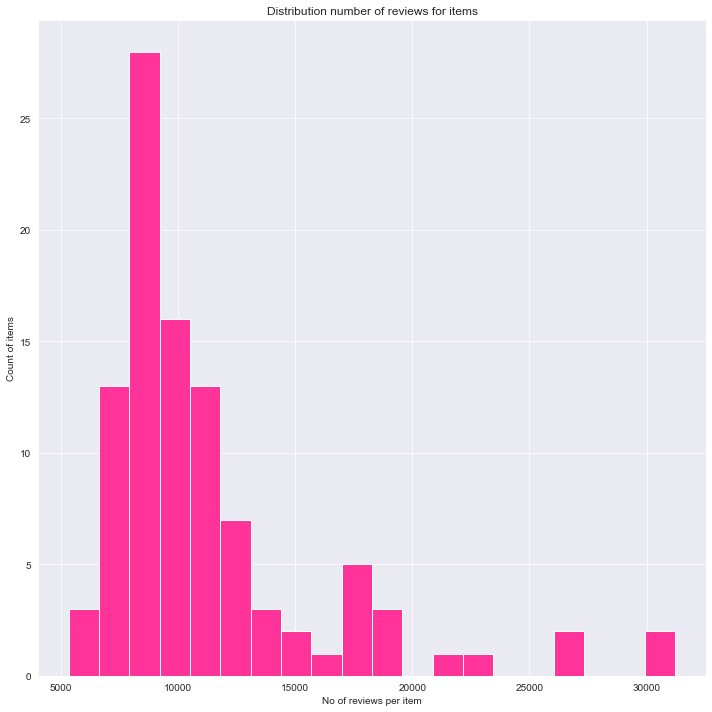

In [ ]:
sns.set_style("darkgrid")
review_per_item = df_matrix.sum(axis=0)
plt.hist(review_per_item,bins=20,color='#ff3399')
plt.xlabel('No of reviews per item')
plt.ylabel('Count of items')
plt.title('Distribution number of reviews for items')
plt.show()

Remove users with less than 14 reviews to reduce no of users as the algorithm takes a lot of time to run.

In [ ]:
items_to_drop=[]
for col,val in df_matrix.sum(axis=1).items():
  if val < 14:
    items_to_drop.append(col)

In [ ]:
print(f'No of items to drop:{len(items_to_drop)}')

No of items to drop:181362


In [ ]:
df_matrix.drop(items_to_drop,axis=0,inplace=True)

In [ ]:
df_matrix.shape

(11303, 100)

### Centered data

#### Normalizing ratings by subtracting row mean

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# mean of the rows
users_mean_rating = df_matrix.mean(axis=1)
# subtract all values by mean of the row
df_mat_norm=df_matrix.sub(users_mean_rating,axis='rows')

In [ ]:
df_mat_norm=df_mat_norm.astype('float16')

In [ ]:
#Convert to matrix
ui_mat_norm = df_mat_norm.values
ui_mat = df_matrix.values

### Cosine similarity

In [ ]:
n_items=ui_mat_norm.shape[1]
sim_matrix={}
# Loop through the columns
for i in range(n_items):
  row_sim=[]
  col = df_matrix.columns[i]
  # Loop through the columns for each column
  for j in range(n_items):
    #sim=cal_cosine_sim(ui_mat_norm[:,i],ui_mat_norm[:,j],ui_mat[:,i],ui_mat[:,j])
    sim=1-spatial.distance.cosine(ui_mat_norm[:,i],ui_mat_norm[:,j])
    row_sim.append(sim)
  sim_matrix[col]=row_sim
  if i%25==0:
    print('item:',i)

item: 0
item: 25
item: 50
item: 75


In [ ]:
# create df of similarity for better visualization
similarity_df=pd.DataFrame.from_dict(sim_matrix,columns=df_matrix.columns,orient='index')
similarity_df.head(10)

,PY9GRfzr4nTZeINf346QOw,W4ZEKkva9HpAdZG88juwyQ,SZU9c8V2GuREDN5KgyHFJw,Zi-F-YvyVOK0k5QD7lrLOg,GBTPC53ZrG1ZBY3DT8Mbcw,pSmOH4a3HNNpYM82J5ycLA,8uF-bhJFgT4Tn6DTb27viA,UCMSWPqzXjd7QHq7v8PJjQ,vN6v8m4DO45Z4pp8yxxF_w,g04aAvgol7IW8buqSbT4xA,...,oBNrLz4EDhiscSlbOl8uAw,skY6r8WAkYqpV7_TxNm23w,iRIHK8-EwpeffwvoO4nzIA,OdIBX09glfXNVSyd0RnIeg,qQO7ErS_RAN4Vs1uX0L55Q,ytynqOUb3hjKeJfRj5Tshw,0RuvlgTnKFbX3IK0ZOOocA,1b5mnK8bMnnju_cvU65GqQ,VAeEXLbEcI9Emt9KGYq9aA,QHWYlmVbLC3K6eglWoHVvA
PY9GRfzr4nTZeINf346QOw,1.00000,-0.00919,0.17407,0.00645,-0.12122,0.05823,-0.02663,0.30835,-0.01654,0.05533,...,-0.06836,0.18628,0.12341,-0.02332,-0.05133,-0.13416,-0.00730,-0.02466,0.04102,0.02667
W4ZEKkva9HpAdZG88juwyQ,-0.00919,1.00000,-0.01185,0.03372,0.04486,-0.03427,-0.01408,-0.02058,-0.00156,0.00692,...,0.01041,-0.00916,-0.01355,-0.05569,-0.05811,-0.06241,-0.05939,-0.02861,-0.03577,-0.03217
SZU9c8V2GuREDN5KgyHFJw,0.17407,-0.01185,1.00000,-0.00419,-0.06775,0.03720,-0.02966,0.20520,-0.02403,0.03046,...,-0.06665,0.37158,0.08606,-0.02054,-0.05096,-0.10883,-0.02423,-0.01226,0.02367,0.00358
Zi-F-YvyVOK0k5QD7lrLOg,0.00645,0.03372,-0.00419,1.00000,0.00575,-0.01866,-0.01279,0.01851,0.00160,0.02112,...,-0.00092,-0.00327,-0.01433,-0.04871,-0.06702,-0.07819,-0.05035,-0.03830,-0.02142,-0.03784
GBTPC53ZrG1ZBY3DT8Mbcw,-0.12122,0.04486,-0.06775,0.00575,1.00000,-0.07098,0.04565,-0.12854,0.04163,-0.04803,...,0.07452,-0.09558,-0.07733,-0.06903,-0.06061,-0.03873,-0.07507,-0.06274,-0.07288,-0.07227
pSmOH4a3HNNpYM82J5ycLA,0.05823,-0.03427,0.03720,-0.01866,-0.07098,1.00000,-0.04169,0.07361,-0.02815,0.00383,...,-0.02927,0.03012,0.04688,-0.04181,-0.04550,-0.06183,-0.03656,0.14551,0.27002,-0.00278
8uF-bhJFgT4Tn6DTb27viA,-0.02663,-0.01408,-0.02966,-0.01279,0.04565,-0.04169,1.00000,-0.01926,0.12830,-0.00898,...,0.02551,-0.02531,-0.01929,-0.06125,-0.05658,-0.07336,-0.06140,-0.03226,-0.04025,-0.02698
UCMSWPqzXjd7QHq7v8PJjQ,0.30835,-0.02058,0.20520,0.01851,-0.12854,0.07361,-0.01926,1.00000,-0.00970,0.07532,...,-0.06451,0.21362,0.16101,-0.02435,-0.05795,-0.15955,-0.01179,-0.01878,0.05725,0.03513
vN6v8m4DO45Z4pp8yxxF_w,-0.01654,-0.00156,-0.02403,0.00160,0.04163,-0.02815,0.12830,-0.00970,1.00000,0.00893,...,0.01994,-0.02150,-0.01447,-0.05444,-0.06262,-0.07831,-0.05710,-0.03827,-0.03613,-0.02888
g04aAvgol7IW8buqSbT4xA,0.05533,0.00692,0.03046,0.02112,-0.04803,0.00383,-0.00898,0.07532,0.00893,1.00000,...,0.03421,0.04367,0.03336,-0.04788,-0.05652,-0.08478,-0.03574,-0.03156,-0.00462,-0.01836


Get item score for each userGet item score for each user

In [ ]:
def cal_score(similarities,history,avgRating):
  nume=np.sum((history-avgRating)*similarities)
  deno=np.sum(similarities)

  return nume/deno

def get_user_score(sim_mat,df,user,user_items,n=10):
  ratings = user_items.values
  mean_user_rate = np.mean(ratings)
  score_vector=[]
  # iterrate over all items
  for item,rate in user_items.items():
    # for item 'i'
    # check if the item 'i' is already rated
    if rate > 0:
      # if rated store -1 so its not recommended
      score = -1
    else:
      # get 10 most similar items to the item 'i'
      # first most similar item is item 'i', hence 1 to n+1
      topN = sim_mat[item].sort_values(ascending=False).iloc[1:n]
      rate_history=df[topN.index].loc[user]
      # get mean item rating
      mean_user_rate=df[topN.index].mean(axis=0)
      score=cal_score(topN.values,rate_history.values,mean_user_rate.values)
    score_vector.append(score)
  return score_vector

In [ ]:
user_score_dict={}
for i,user in enumerate(df_matrix.index):
  if i%1000==0:
    print('user:',i)
  user_items = df_matrix.loc[user]
  user_score=get_user_score(similarity_df,df_matrix,user_items.name,user_items)
  user_score_dict[user] = user_score

user: 0
user: 1000
user: 2000
user: 3000
user: 4000
user: 5000
user: 6000
user: 7000
user: 8000
user: 9000
user: 10000
user: 11000


In [ ]:
# create a data frame of user item score
user_item_score=pd.DataFrame.from_dict(user_score_dict,orient='index',columns=df_matrix.columns)
user_item_score.head()

,PY9GRfzr4nTZeINf346QOw,W4ZEKkva9HpAdZG88juwyQ,SZU9c8V2GuREDN5KgyHFJw,Zi-F-YvyVOK0k5QD7lrLOg,GBTPC53ZrG1ZBY3DT8Mbcw,pSmOH4a3HNNpYM82J5ycLA,8uF-bhJFgT4Tn6DTb27viA,UCMSWPqzXjd7QHq7v8PJjQ,vN6v8m4DO45Z4pp8yxxF_w,g04aAvgol7IW8buqSbT4xA,...,oBNrLz4EDhiscSlbOl8uAw,skY6r8WAkYqpV7_TxNm23w,iRIHK8-EwpeffwvoO4nzIA,OdIBX09glfXNVSyd0RnIeg,qQO7ErS_RAN4Vs1uX0L55Q,ytynqOUb3hjKeJfRj5Tshw,0RuvlgTnKFbX3IK0ZOOocA,1b5mnK8bMnnju_cvU65GqQ,VAeEXLbEcI9Emt9KGYq9aA,QHWYlmVbLC3K6eglWoHVvA
EBa-0-6AKoy6jziNexDJtg,-0.02740,-1.00000,-0.03901,0.98211,-1.00000,-0.18048,-0.26671,-0.02929,-0.05948,-0.05926,...,-1.00000,-0.04075,-0.04578,-0.32083,-0.31735,-0.27639,-0.29907,-0.18327,-0.17945,-0.13787
JYYYKt6TdVA4ng9lLcXt_g,-0.02740,-0.32274,-1.00000,0.29686,0.37888,-0.18048,0.35440,-0.02929,0.41665,-0.05926,...,-0.05207,0.66173,-0.04578,-0.32083,-0.31735,-0.27639,-0.29907,-0.18327,-0.17945,-0.13787
pitYOVSsF8R1gWG1G0qxsA,-0.02740,0.05062,-0.03901,-0.26386,-1.00000,-0.18048,-0.26671,-0.02929,-0.05948,0.34812,...,0.07513,-0.04075,0.59358,-0.32083,-0.31735,-0.27639,-0.29907,-0.18327,-0.17945,-0.13787
1xS8Jj23zHx8axIVopG3wA,-0.02740,-1.00000,-0.03901,0.17783,0.15293,-0.18048,-0.26671,-0.02929,-0.31941,-0.05926,...,0.31592,-0.04075,-0.04578,-0.32083,-0.31735,-0.27639,-0.29907,-0.18327,-0.17945,-0.13787
ftRgzVFzv6-TOCBXEOdWeQ,-0.02740,0.67574,-0.03901,0.28825,-1.00000,-0.18048,-1.00000,-0.02929,1.00693,0.52146,...,1.11606,-0.04075,-0.04578,-0.32083,-0.31735,-0.27639,-0.29907,-0.18327,-0.17945,-0.13787


In [ ]:
user_item_recomend = pd.DataFrame(columns=['1','2','3','4','5'])

In [ ]:
# get top 5 recommendation for every user
for idx in user_item_score.index:
  user_pref=user_item_score.loc[idx]
  user_pref=user_pref.sort_values(ascending=False)[0:5]
  user_item_recomend.loc[idx] = list(user_pref.index)

In [ ]:
user_item_recomend.head()

,1,2,3,4,5
EBa-0-6AKoy6jziNexDJtg,iwmW2mgcn2YdirXUHCsgXQ,Zi-F-YvyVOK0k5QD7lrLOg,c-iKAO2GBzSKjm7y1Oljcw,ww3YJXu5c18aGZXWmm00qg,Vz2RN55rTJBGn43K1v84nA
JYYYKt6TdVA4ng9lLcXt_g,U3grYFIeu6RgAAQgdriHww,ww3YJXu5c18aGZXWmm00qg,skY6r8WAkYqpV7_TxNm23w,yPSejq3_erxo9zdVYTBnZA,GuzbBFraIq-fbkjfvaTRvg
pitYOVSsF8R1gWG1G0qxsA,iRIHK8-EwpeffwvoO4nzIA,2BMk_drsikKWslJCXmQtjQ,UFCN0bYdHroPKu6KV5CJqg,g04aAvgol7IW8buqSbT4xA,BjeHLwKOlHyV6DJgmZxAjA
1xS8Jj23zHx8axIVopG3wA,Y2Pfil51rNvTd_lFHwzb_g,ChlcxTEoWBQJXJ2Xb2vm5g,iSRTaT9WngzB8JJ2YKJUig,VaO-VW3e1kARkU9bP1E7Fw,RLlOK2fL6xU1sfIPiP2QBw
ftRgzVFzv6-TOCBXEOdWeQ,Vz2RN55rTJBGn43K1v84nA,V9VLhHdSFpFi4yXFqVcVEA,hfbZ97Te3T4jeWN6GgsGrQ,oBNrLz4EDhiscSlbOl8uAw,vN6v8m4DO45Z4pp8yxxF_w


### Collaborative filtering using Stochastic Gradient

#### Create continous values for unique buisness_id and user_id which are of the form string

In [ ]:
df_restaurant = pd.read_csv('csv/df_restaurant.csv')

In [ ]:
items=df_restaurant.business_id.unique()
users=df_restaurant.user_id.unique()

In [ ]:
userid2idx = {o:i for i,o in enumerate(users)}
items2idx = {o:i for i,o in enumerate(items)}

In [ ]:
df_restaurant['business_id']=df_restaurant['business_id'].apply(lambda x: items2idx[x])
df_restaurant['user_id']=df_restaurant['user_id'].apply(lambda x: userid2idx[x])

In [ ]:
df_restaurant.head()

,user_id,business_id,stars
0,0,0,3
1,1,1,3
2,2,2,5
3,3,3,4
4,4,4,1


In [ ]:
# unique users and items
nitems=df_restaurant.business_id.nunique()
nusers=df_restaurant.user_id.nunique()

In [ ]:
nusers,nitems

(1504895, 64577)

### Train test split

In [ ]:
train_idx, val_idx = train_test_split(range(df_restaurant.shape[0]), train_size=0.7,random_state=2971)
df_train= df_restaurant.iloc[train_idx]
df_validate = df_restaurant.iloc[val_idx]
df_train.shape, df_validate.shape

((4611978, 3), (512443, 3))

In [ ]:
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flattened')(x)

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [ ]:
L = 45
REG=8e-4

In [ ]:
# Create embeddings 
user_input, mat_user_lf = embedding_input('user_input', nusers, L, REG)
restraunts_input, mat_restau_lf = embedding_input('restraunts_input', nitems, L, REG)

In [ ]:
# Create bias
user_bias = create_bias('user_bias', user_input, nusers, REG)
restraunts_bias = create_bias('movie_bias', restraunts_input, nitems, REG)

In [ ]:
# create residuals matrix
residual = Dot(axes=2, name="residual")([mat_user_lf, mat_restau_lf])
# Flatten the layer
residual_flatten = Flatten(name="residual_flat")(residual)

In [ ]:
# regression layer
regression = Add(name="regression")([user_bias, restraunts_bias, residual_flatten])

In [ ]:
# Create a tailor made sigmoid to keep output values within range 0-5
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid
cs = sigmoid_maker(0, 5.5)

In [ ]:
output = Activation(cs, name="Sigmoid")(regression)

In [ ]:
model_lf1 = Model([user_input, restraunts_input], output)
model_lf1.compile(Adam(0.01), loss='mse')

In [ ]:
model_lf1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
restraunts_input (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 45)        67720275    user_input[0][0]                 
__________________________________________________________________________________________________
restraunts_factor (Embedding)   (None, 1, 45)        2905965     restraunts_input[0][0]           
______________________________________________________________________________________________

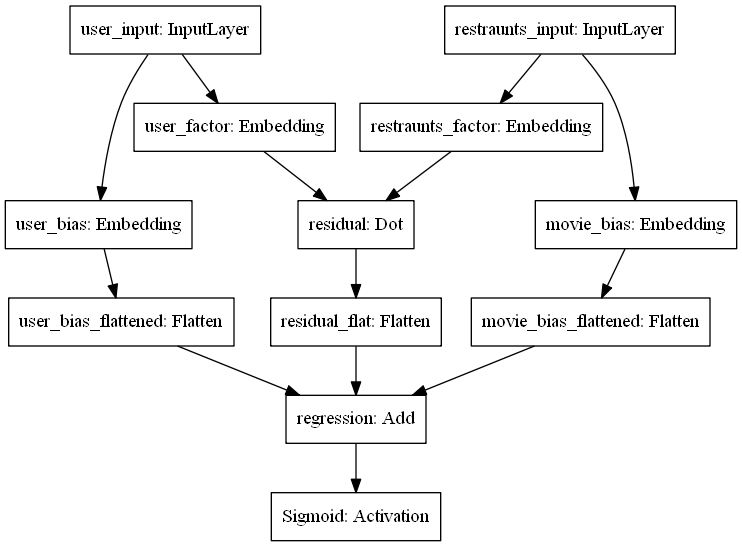

In [ ]:
tf.keras.utils.plot_model(model_lf1)

In [ ]:
history_lf1=model_lf1.fit([df_train.user_id, df_train.business_id], df_train.stars, batch_size=1024, epochs=3, validation_data=([df_validate.user_id, df_validate.business_id], df_validate.stars))

In [ ]:
# plotting history 
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=(8,5)
plt.plot(history_lf1.history['loss'],label='Training Loss',color='red')
plt.plot(history_lf1.history['val_loss'],label='Validation Loss',color='green')
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Model Loss',fontsize=15)
plt.title('Model Performance: Loss Plot',fontsize=18)
plt.legend()

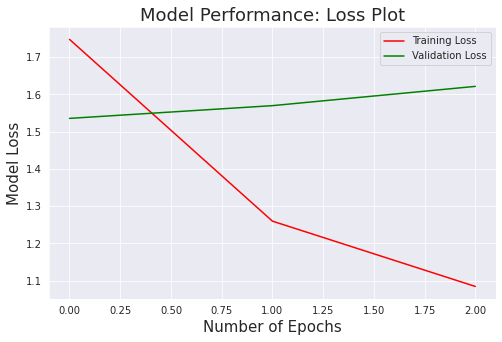

In [ ]:
Image(filename='lossplot_sgd.png')

### Hybrid Approach

In [ ]:
users_review_count=df_restaurant.groupby('user_id')['stars'].count()
freq_users=[]
for i,val in users_review_count.items():
  if val>2:
    freq_users.append(i)
df_restaurant=df_restaurant[df_restaurant['user_id'].isin(freq_users)]

In [ ]:
most_rated_items=df_restaurant.groupby(['business_id'])['business_id'].count()
popular_rest=[]
for i,val in most_rated_items.items():
  if val>1:
    popular_rest.append(i)
df_restaurant=df_restaurant[df_restaurant['user_id'].isin(popular_rest)]
df_restaurant.reset_index(drop=True,inplace=True)

### Users-Products matrix

In [ ]:
items=df_restaurant.business_id.unique()
users=df_restaurant.user_id.unique()

In [ ]:
userid2idx = {o:i for i,o in enumerate(users)}
items2idx = {o:i for i,o in enumerate(items)}

In [ ]:
df_restaurant.head()

,user_id,business_id,stars
0,DBYhpb5hrAYgQjQaMhNYyQ,oJ4ik-4PZe6gexxW-tSmsw,4
1,XTWdXSOoUJnIMiVSA-1gDg,_RwlMTw9uFeOkfX9Ctf1HA,1
2,f6B7YotlkKfXr9xN-TbpwA,Bt7NBqA31uOI4H_hvasLLg,5
3,Fp0SeuMpAzcwPITfyF95hA,DuPRwh_pNsp4LkbICuF3Ig,4
4,DBYhpb5hrAYgQjQaMhNYyQ,JJNCJWaH2KV44r9aeEBlqA,4


In [ ]:
df_restaurant['business_id']=df_restaurant['business_id'].apply(lambda x: items2idx[x])
df_restaurant['user_id']=df_restaurant['user_id'].apply(lambda x: userid2idx[x])

In [ ]:
def make_user_item_matrix(user_item,df):
  len_UI = user_item.shape[0]
  for i in range(len_UI):
    index = user_item['user_id'].iloc[i]
    col = user_item['business_id'].iloc[i]
    rate = user_item['stars'].iloc[i]
    df[col].loc[index]=rate

  return df


In [ ]:

unique_items = df_restaurant.business_id.unique()
unique_user = df_restaurant['user_id'].unique()
null_ui_mat={}
for i in unique_user:
  r = list(np.zeros(len(unique_items)))
  null_ui_mat[i]=r
  
UI_matrix = pd.DataFrame.from_dict(null_ui_mat,columns=unique_items,orient='index').astype('int32')

In [ ]:
UI_matrix=make_user_item_matrix(df_restaurant,UI_matrix)

In [ ]:
UI_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712
0,4,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
UI_matrix = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(UI_matrix.values), 
columns=UI_matrix.columns, index=UI_matrix.index)

In [ ]:
split = int(0.7*UI_matrix.shape[1])
df_train = UI_matrix.loc[:, :split-1]
df_val = UI_matrix.loc[:, split:]

In [ ]:
train = df_train.stack(dropna=True).reset_index().rename(columns={'level_0':'user','level_1':'items',0:"y"})
train.head()

,user,items,y
0,0,0,1.0
1,0,1,0.5
2,0,2,0.5
3,0,3,0.5
4,0,4,1.0


In [ ]:
val = df_val.stack(dropna=True).reset_index().rename(columns={'level_0':'user','level_1':'items',0:"y"})

In [ ]:
embeddings_shape = 50
user,items = UI_matrix.shape[0], UI_matrix.shape[1]

In [ ]:
nusers_in = Input(name="nusers_in", shape=(1,))
nproducts_in = Input(name="nproducts_in", shape=(1,))

### Matrix factorization

In [ ]:
mf_nusers_emb = Embedding(name="cf_nusers_emb", input_dim=user, output_dim=embeddings_shape)(nusers_in)
mf_nusers = Reshape(name='cf_nusers', target_shape=(embeddings_shape,))(mf_nusers_emb)

In [ ]:
mf_nproducts_emb = Embedding(name="cf_nproducts_emb", input_dim=items, output_dim=embeddings_shape)(nproducts_in)
mf_nproducts = Reshape(name='cf_nproducts', target_shape=(embeddings_shape,))(mf_nproducts_emb)

In [ ]:
mf_product = Dot(name='cf_product', normalize=True, axes=1)([mf_nusers, mf_nproducts])

### Neural Network

In [ ]:
nn_nusers_emb = Embedding(name="nn_nusers_emb", input_dim=user, output_dim=embeddings_shape)(nusers_in)
nn_nusers = Reshape(name='nn_nusers', target_shape=(embeddings_shape,))(nn_nusers_emb)

In [ ]:
nn_nproducts_emb = Embedding(name="nn_nproducts_emb", input_dim=items, output_dim=embeddings_shape)(nproducts_in)
nn_nproducts = Reshape(name='nn_nproducts', target_shape=(embeddings_shape,))(nn_nproducts_emb)

In [ ]:
nn_product = Concatenate()([nn_nusers, nn_nproducts])
nn_product = Dense(name="nn_product", units=int(embeddings_shape/2), activation='relu')(nn_product)

### Merging both

In [ ]:
y_out = Concatenate()([mf_product, nn_product])
y_out = Dense(name="y_out", units=1, activation='linear')(y_out)

In [ ]:
model_h = Model(inputs=[nusers_in,nproducts_in], outputs=y_out, name="Hybrid_filtering")

In [ ]:
model_h.summary()

Model: "Hybrid_filtering"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nusers_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
nproducts_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nn_nusers_emb (Embedding)       (None, 1, 50)        14300       nusers_in[0][0]                  
__________________________________________________________________________________________________
nn_nproducts_emb (Embedding)    (None, 1, 50)        135650      nproducts_in[0][0]               
___________________________________________________________________________________

In [ ]:
model_h.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])

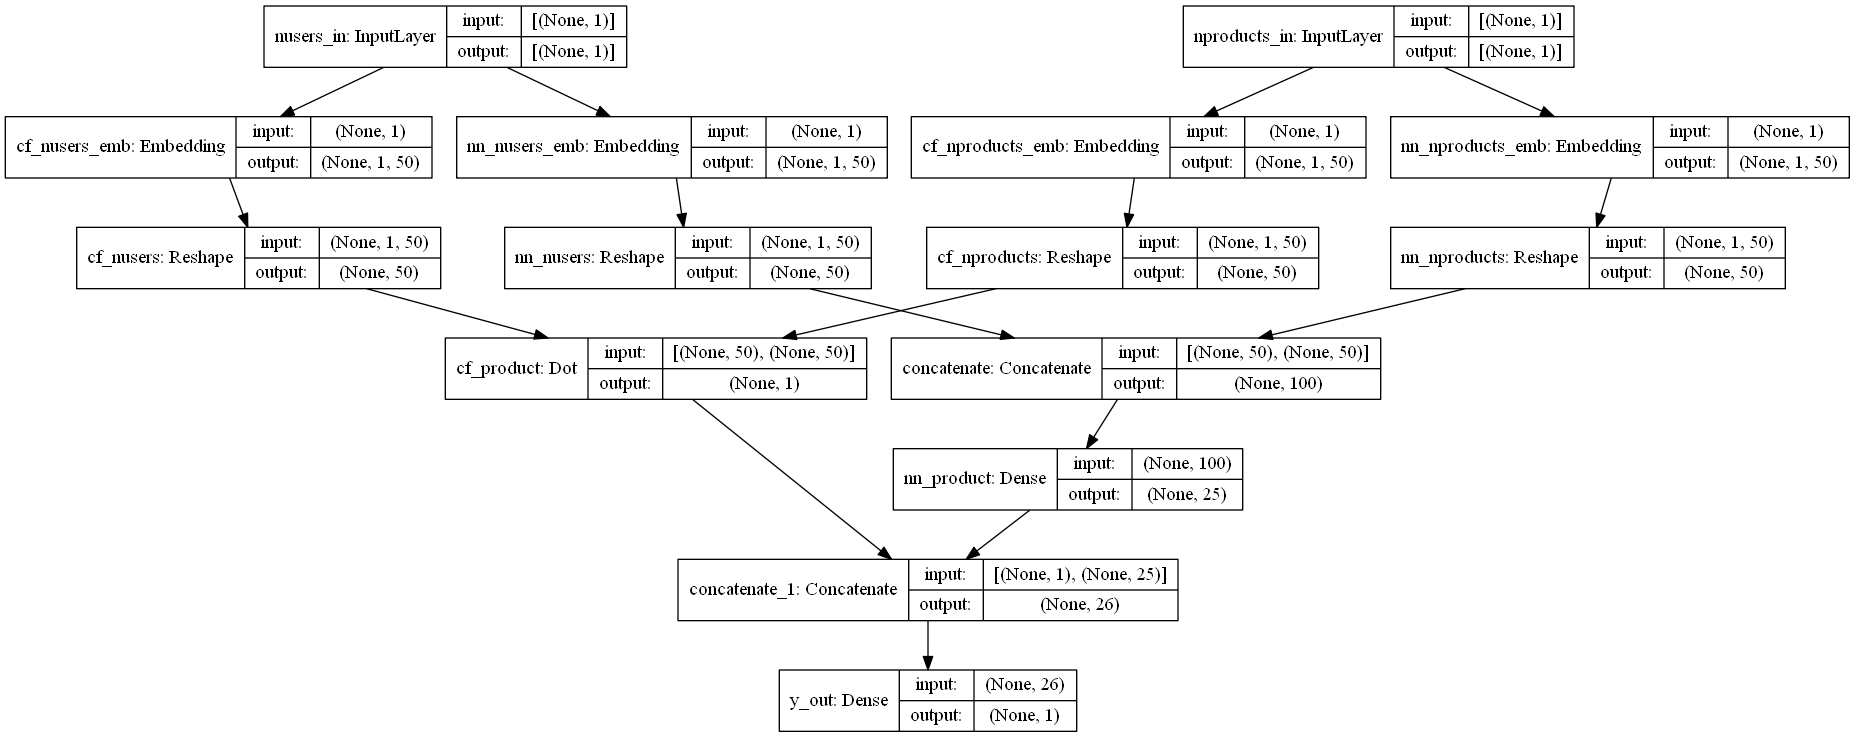

In [ ]:
utils.plot_model(model_h, show_shapes=True, show_layer_names=True)

In [ ]:
history_lf1 = model_h.fit(x=[train["user"], train["items"]], y=train["y"], epochs=10, batch_size=64, shuffle=True, validation_split=0.3)

Epoch 1/10
5941/5941 [==============================] - 25s 4ms/step - loss: 0.0074 - mean_absolute_percentage_error: 1.2396 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 0.4274
Epoch 2/10
5941/5941 [==============================] - 25s 4ms/step - loss: 0.0030 - mean_absolute_percentage_error: 0.3632 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 0.2937
Epoch 3/10
5941/5941 [==============================] - 25s 4ms/step - loss: 0.0031 - mean_absolute_percentage_error: 0.3731 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 0.2130
Epoch 4/10
5941/5941 [==============================] - 24s 4ms/step - loss: 0.0030 - mean_absolute_percentage_error: 0.3668 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 0.2118
Epoch 5/10
5941/5941 [==============================] - 24s 4ms/step - loss: 0.0030 - mean_absolute_percentage_error: 0.3608 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 0.2461
Epoch 6/10
5941/5941 [==============================] -

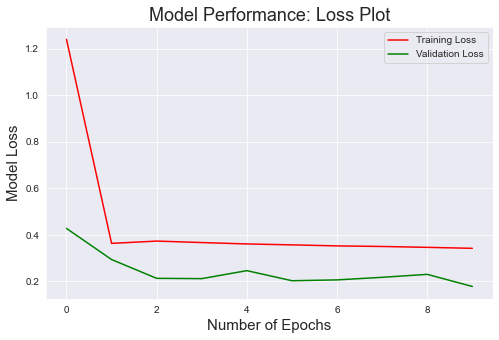

In [ ]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=(8,5)
plt.plot(history_lf1.history['mean_absolute_percentage_error'],label='Training Loss',color='red')
plt.plot(history_lf1.history['val_mean_absolute_percentage_error'],label='Validation Loss',color='green')
plt.xlabel('Number of Epochs',fontsize=15)
plt.ylabel('Model Loss',fontsize=15)
plt.title('Model Performance: Loss Plot',fontsize=18)
plt.legend()
plt.show()

## Conclusion
We tried different types of techniques to build a restaurant recommendation system. <br>
EDA helped us gather insights about the data which helped in model building. The first cosine similarity based collaborative model was the starting point.<br>
Moving on to the neural netowrk based models, the first one overfit the training data in just 3 epochs, so we decided to land on a hybrid model which performed far more better than the previous one.<br>